### Reading data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

csv_file = "data/sonar_3_data.csv"
col_names = ["time", "seq", "stamp", "frame_id", "s0", "s1", "s2", "s3", "s4", "s5", "s6", "s7", "s8", "s9"]
df = pd.read_csv(csv_file, names=col_names, header=0, usecols=range(4, 14))
df = df.applymap(lambda x: np.nan if x == -1 else x)  # Set -1 to NaN
df

,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9
0,987,1018,1232,2774.0,594.0,1281.0,1238.0,952,1885.0,878
1,978,1028,1109,2589.0,594.0,1415.0,1238.0,921,1885.0,989
2,997,1018,1222,2579.0,594.0,1425.0,1259.0,972,1885.0,930
3,977,1028,1119,2785.0,594.0,1415.0,1249.0,1002,1885.0,878
4,977,1038,1129,2579.0,604.0,1435.0,1259.0,962,1885.0,909
...,...,...,...,...,...,...,...,...,...,...
7207,976,1007,1170,2774.0,594.0,1415.0,1249.0,956,987.0,945
7208,977,1007,1037,2785.0,583.0,1415.0,1238.0,962,972.0,905
7209,974,1029,1202,2785.0,594.0,1426.0,1250.0,1013,1002.0,951
7210,967,1028,1160,2774.0,594.0,1425.0,1238.0,992,1875.0,878


### Time consuming data preparation

In [2]:
range_data_list = []
for i in range(df.shape[0]):
    range_data_list.append(list(df.iloc[i]))

### Callback function

In [3]:
class CountData:
    def __init__(self):
        self.total = 0
        self.in_range = 0
        self.good = 0

    def get_good_ratio(self):
        try:
            return self.good / self.in_range
        except ZeroDivisionError:
            return 0

    def get_in_range_ratio(self):
        return self.in_range / self.total

    def __repr__(self):
        str = f"All: {self.total}, Range: {self.get_in_range_ratio():2.2f} {self.in_range:5} "
        str += f"Good: {self.good:5}, {self.get_good_ratio():2.2f}"
        return str


SONAR_COUNT = 10
# sonar_hist = [[] for _ in range(SONAR_COUNT]

# range_sonar_msg = Range()
# range_bump_msg = Range()
# sonar_max_ranges = [0.4] + [0.5, ] * 8 + [0.4]  # NOTE: tuning filter. Found experimentally

# sonar_max_ranges = [0.0, ] * 10  # TODO: delete test
# sonar_max_ranges[3] = 1
# sonar_max_ranges[6] = 1


def sonar_callback(range_data, sonar_count=SONAR_COUNT):
    """
        Republishes filtered received distances array to Range messages
    """
    #     global sonar_pub, sonar_pub_all, range_sonar_msg, sonar_max_ranges, sonar_hist
    global sonar_max_ranges, sonar_hist, SONAR_COUNT, HIST_COUNT, RANGE_THRESH

    #     time_now = rospy.Time.now()
    for i in range(sonar_count):
        # Setup message info
        #         range_sonar_msg.header.frame_id = "ultrasonic_%d" % (i + 1)
        #         range_sonar_msg.header.stamp = time_now
        #         range_sonar_msg.max_range = sonar_max_ranges[i]  # Set each max range different
        dist = range_data[i] / 1000.0  # Distance in meters | range_data.data[i]
        #         range_sonar_msg.range = dist

        #         # Filter range data
        #         HIST_COUNT = 2  # NOTE: tuning range filter. Sonar range history count. 2 Looks good
        sonar_hist[i].append(dist)
        while len(sonar_hist[i]) > HIST_COUNT:
            sonar_hist[i].pop(0)

        # NOTE: tuning range filter. Threshold in meters.
        # Outlier filter: all values in history must be similar to the last one
        #         RANGE_THRESH = 0.10
        outlier = False
        for sh in sonar_hist[i]:
            # If atleast one reading isn't in range don't send the message
            if abs(dist - sh) > RANGE_THRESH:
                outlier = True
                break

        # Counter -------
        c[i].total += 1
        c[i].in_range += 1 if dist < sonar_max_ranges[i] else 0
        c[i].good += 1 if dist < sonar_max_ranges[i] and outlier is False else 0

    #         if outlier is False:
    #             sonar_pub.publish(range_sonar_msg)

    #         # Debug all sonar ranges  # TODO: delete
    #         range_sonar_msg.max_range = 10.0
    #         sonar_pub_all.publish(range_sonar_msg)

    return c

### Imitate topic publishing and compute data

In [4]:
def single_test(sonar_count=SONAR_COUNT):
    global c, sonar_max_ranges, HIST_COUNT, RANGE_THRESH

    sonar_hist = [[] for _ in range(sonar_count)]

    data_count = df.shape[0]
    for i in range(data_count):
        c = sonar_callback(range_data_list[i], sonar_count)
    #     for i, cc in enumerate(c):
    #         print(f"{i}. {cc}")
    return c

SONAR_MAX_RANGES = [0.4] + [0.5,] * 8 + [0.4]
def set_values(r=SONAR_MAX_RANGES, h=2, t=0.1):
    global c, sonar_hist, sonar_max_ranges, HIST_COUNT, RANGE_THRESH

    c = [CountData() for _ in range(SONAR_COUNT)]
    sonar_hist = [[] for _ in range(SONAR_COUNT)]

    sonar_max_ranges = r
    HIST_COUNT = h
    RANGE_THRESH = t

Time consuming

In [5]:
HIST_RANGE = range(2, 26, 4)
MAX_RANGE_RANGE = np.arange(0.15, 1.2, 0.1)
TRESH_RANGE = np.arange(0.0, 0.2, 0.02)

# RANGE_1 = MAX_RANGE_RANGE
RANGE_1 = HIST_RANGE
RANGE_2 = TRESH_RANGE

c_good_list = [[[] for _ in RANGE_2] for _ in RANGE_1]
c_good_list_num = [[[] for _ in RANGE_2] for _ in RANGE_1]
# for i, h in enumerate(HIST_RANGE):
# for i, r in enumerate(RANGE_1):
for i, h in enumerate(RANGE_1):
    for j, t in enumerate(RANGE_2):
        #         set_values(t=t, h=h)
#         set_values(r=[r, ] * SONAR_COUNT, t=t, h=i)
        set_values(r=SONAR_MAX_RANGES, t=t, h=h)
        c = single_test()
        c_good_list[i][j] = [round(x.get_good_ratio(), 2) for x in c]
        c_good_list_num[i][j] = [x.good for x in c]

#         for i, x in enumerate(c_good_list):
#             print(f"{i}. {x}\n")
#         print("-----")

# for i, x in enumerate(c_good_list):
#     print(f"{i}. {x}\n")

### Plotting data
This plots what factor of sonar readings (which are withing max range) are accepted with respect to 2 tuning variables T range treshold and H history count. As seen factor 0.2 is normal at defaul param: H=2 T=0.1.
Some of the sensors are doing poorly and are almost fully filtered out which is bad.



Good data / In range data = fraction




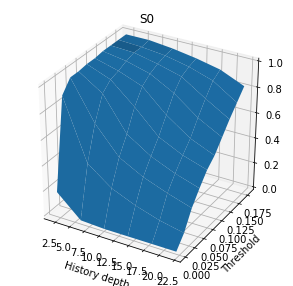

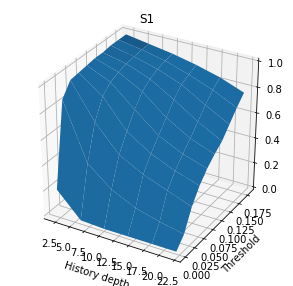

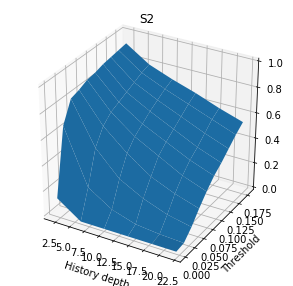

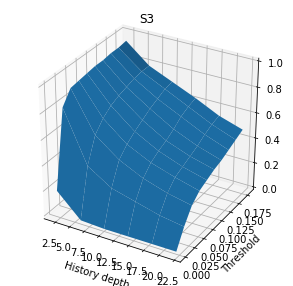

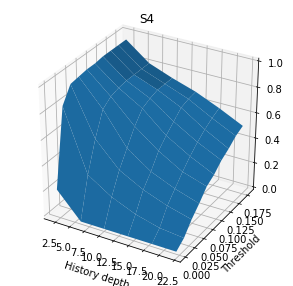

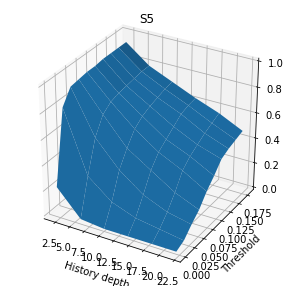

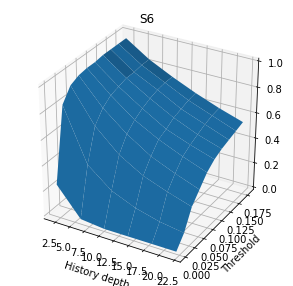

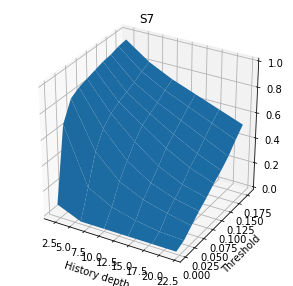

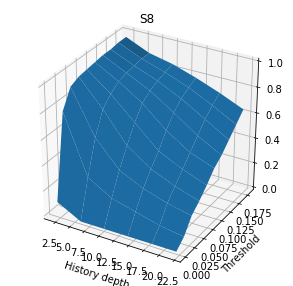

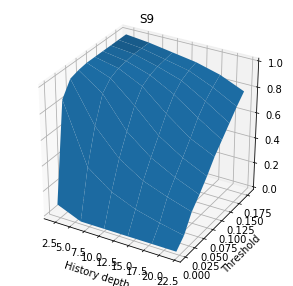



Good data and in range count




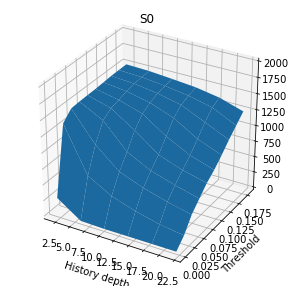

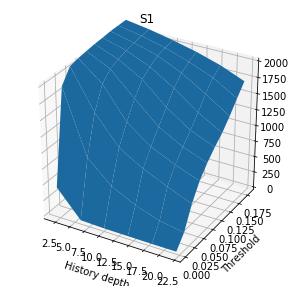

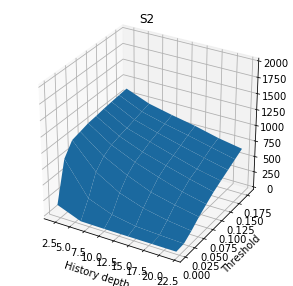

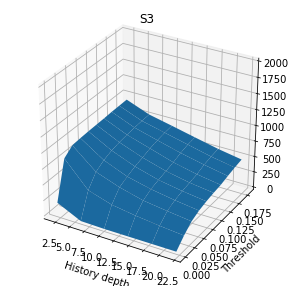

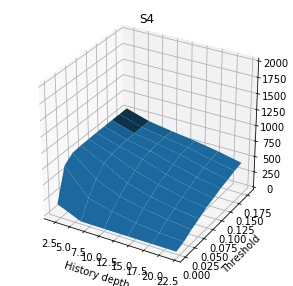

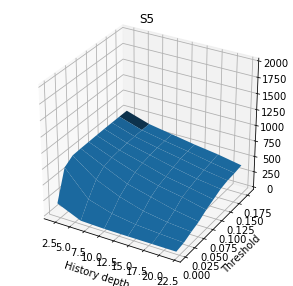

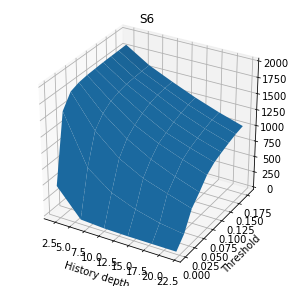

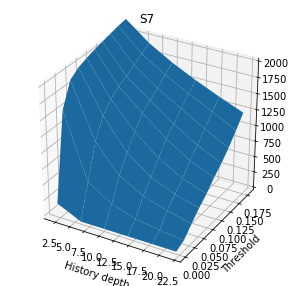

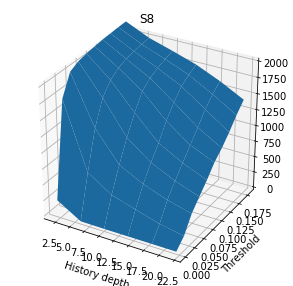

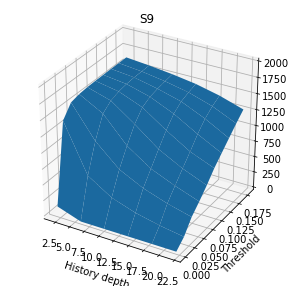

In [12]:
%matplotlib inline
# %matplotlib notebook
import numpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def plot_sonar(data_list, ind=0, zlim=(0, 1)):
    # Set up grid and test data
    nx, ny = (len(data_list), len(data_list[0]))
    x = range(nx)
    y = range(ny)

    data = []
    for i in x:
        data.append([])
        for j in y:
            data[i].append(data_list[i][j][ind])

    data = np.array(data, dtype=np.float32)
    data = data.transpose()

    #     plt.subplot(SONAR_COUNT, ind+1, 1, projection='3d')
    hf = plt.figure(figsize=(5, 5))
    ha = hf.add_subplot(111, projection="3d")

    #     x = HIST_RANGE
    x = RANGE_1
    y = RANGE_2
    X, Y = numpy.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
    ha.plot_surface(X, Y, data)
    plt.title(f"S{ind}")
#     plt.xlabel("Max Range")
    plt.xlabel("History depth")
    plt.ylabel("Threshold")
    ha.set_zlim(zlim[0], zlim[1])
    plt.show()


print("\n\nGood data / In range data = fraction\n\n")
for i in range(SONAR_COUNT):
    plot_sonar(c_good_list, i)

print("\n\nGood data and in range count\n\n")
for i in range(SONAR_COUNT):
#     plot_sonar(c_good_list_num, i, zlim=(0, df.shape[0]))
    plot_sonar(c_good_list_num, i, zlim=(0, 2000))

### Other 2d graphing

In [7]:
c_range_list = []
tmp_range = np.arange(0, 4.5, 0.25)
for i, r in enumerate(tmp_range):
    set_values(r=[r,] * SONAR_COUNT)
    c = single_test()
    c_range_list.append([round(x.get_in_range_ratio(), 2) for x in c])

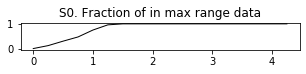

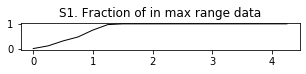

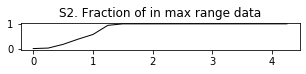

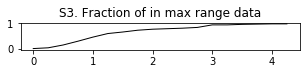

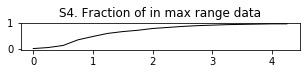

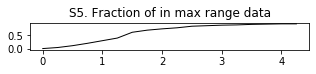

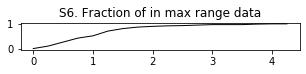

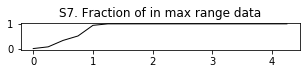

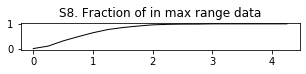

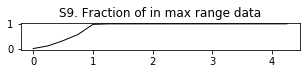

In [8]:
for i in range(len(c)):
    plt.figure(figsize=(5, 0.5))
    plt.title(f"S{i}. Fraction of in max range data")
    plt.plot(tmp_range, [x[i] for x in c_range_list], "k-", lw=1)
    plt.show()

### Plot 2d graph
Black line - sonar data

Yellow lines - threshold limit in mm

Red line - fraction of values included (0..1000) x, threshold limit y

In [9]:
# Get delta/change DataFrame
dfd = pd.DataFrame()
for i in range(SONAR_COUNT):
    sname = f"s{i}"
    y=list(df[sname])
    dy = [abs(y[n]-y[n-1]) for n in range(len(y))]
    dfd.loc[:, sname] = dy

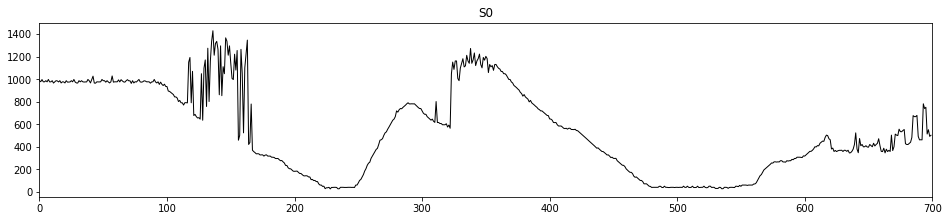

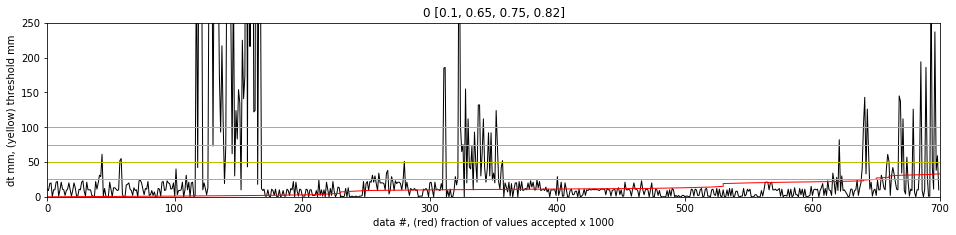

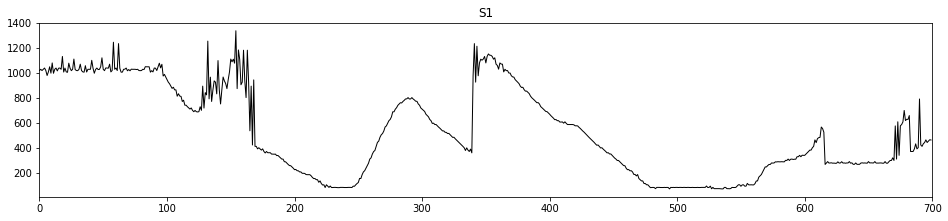

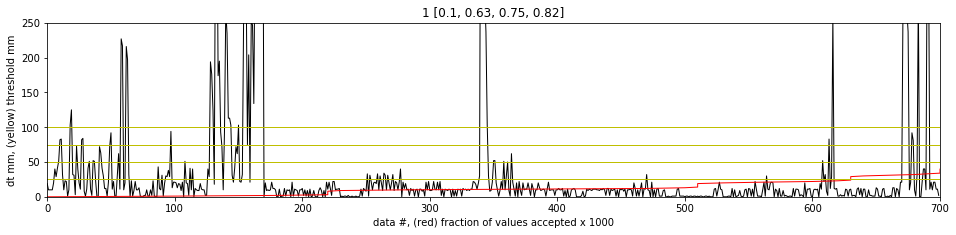

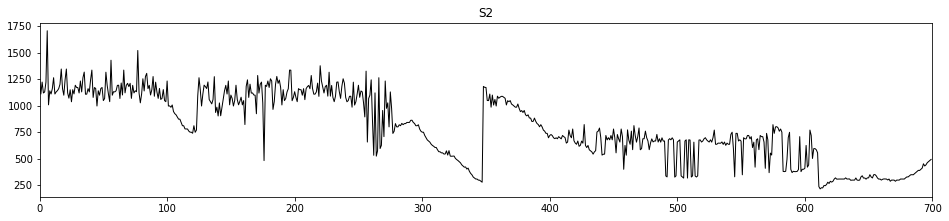

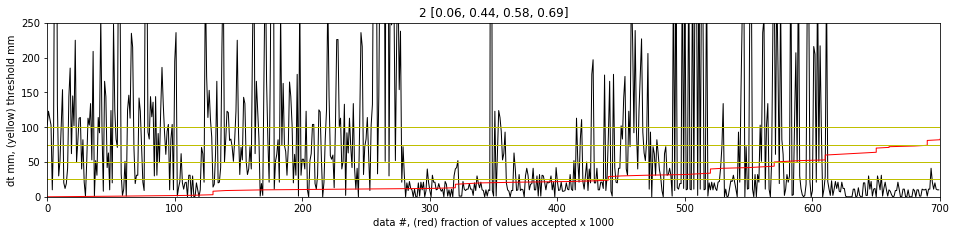

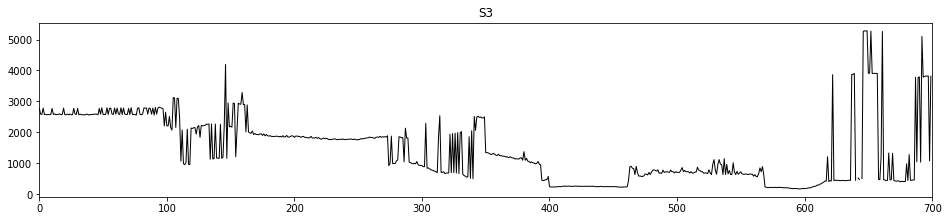

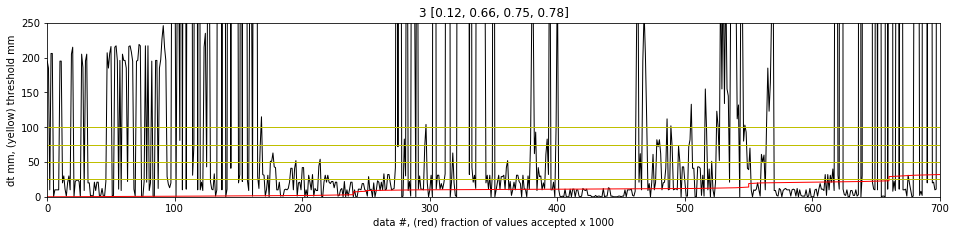

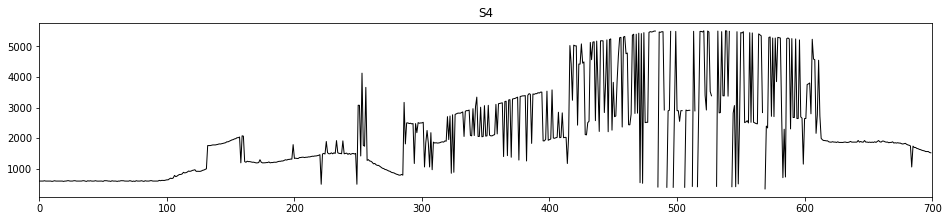

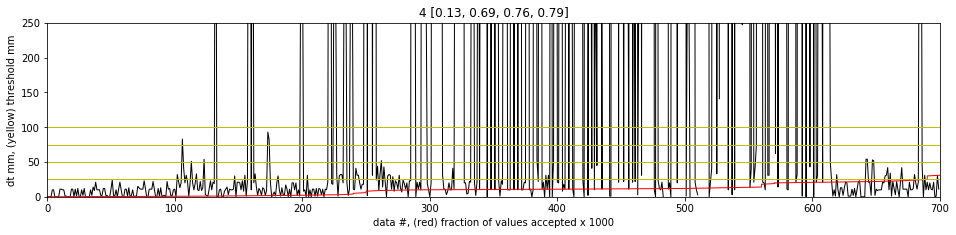

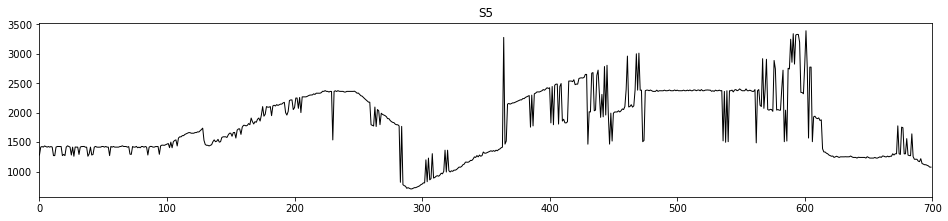

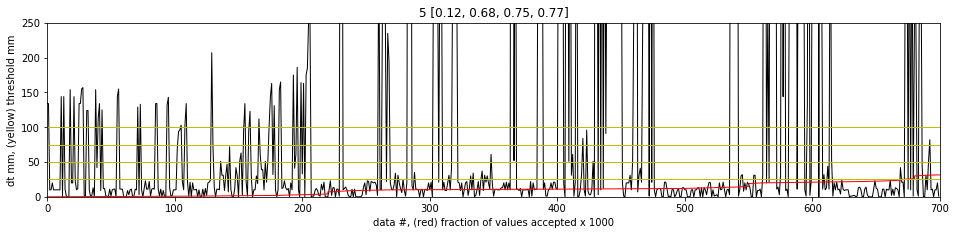

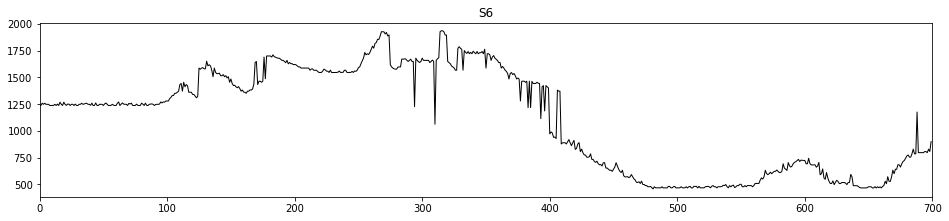

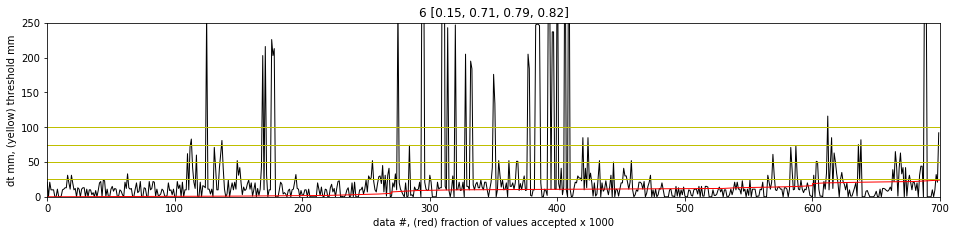

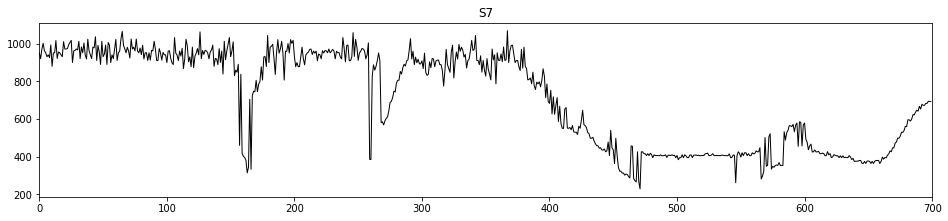

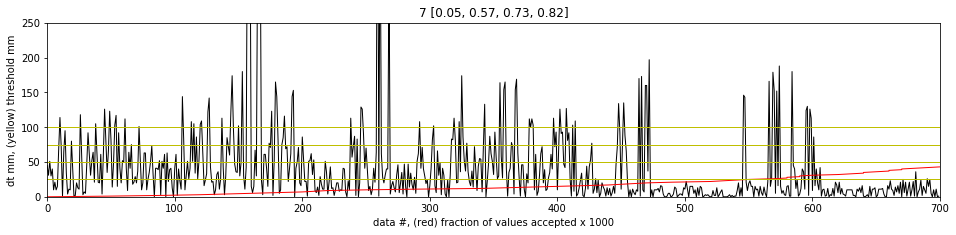

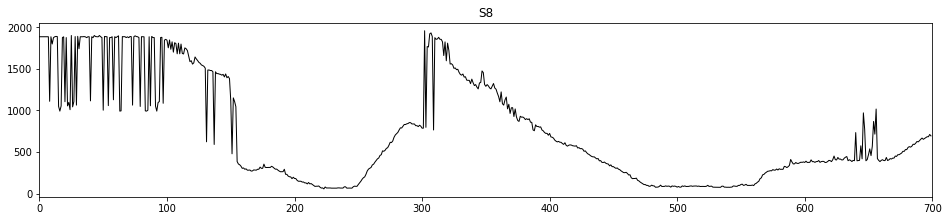

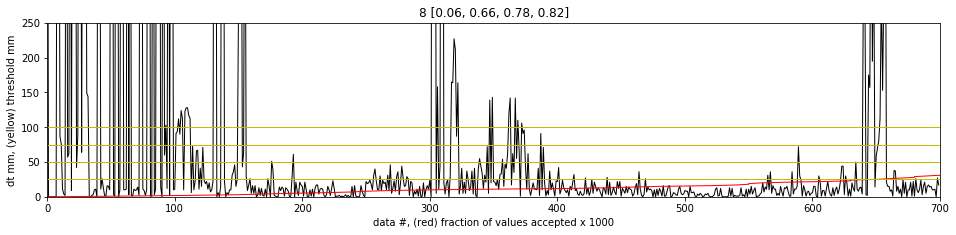

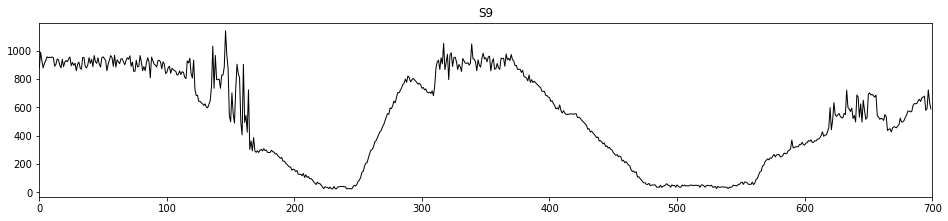

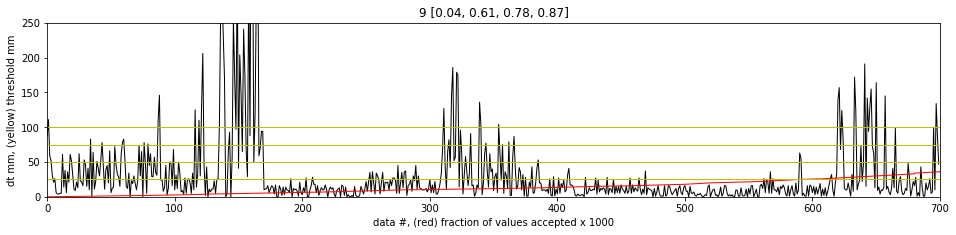

In [16]:
# %matplotlib notebook
%matplotlib inline

for i in range(SONAR_COUNT):
    sname = f"s{i}"
    sonar = df[sname]
    d_sonar = dfd[sname]

    if True:
        a = 0
        b = min(a + 700, df.s0.count())

        #         y[50:100] = [np.nan, ] * 50
        #         y = np.array(y)
        #         dy = np.array(dy)
        #         y[dy > 7] = np.nan
        #         y = [j if dj < 3  else float('nan') for j, dj in zip(y, dy)]

        w, h = plt.figaspect(0.2)
        plt.figure(figsize=(w, h))
        #         fig, ax1 = plt.subplots()
        #         ax1 = plt.subplot(SONAR_COUNT, 1, i + 1)

        plt.title(f"S{i}")
        plt.xlim(a, b)
        # plt.plot(dfff.index[a:b], dfff[sname][a:b], "b")
        #         plt.ylim(0, 900)
        plt.plot(df.index[a:b], df[sname][a:b], "k-", lw=1)
        plt.show()

        #         delta_checks = (25, 50, 75, 100)
        delta_checks = [x for x in range(0, 201)]
        delta_frac = [round(d_sonar[d_sonar < x].count() / d_sonar.shape[0], 2) for x in delta_checks]

        plt.figure(figsize=(w, h))
        plt.title(f"{i} {delta_frac[1:101:25]}")
        plt.xlim(a, b)
        plt.ylim(0, +250)
        plt.xlabel("data #, (red) fraction of values accepted x 1000")
        plt.ylabel("dt mm, (yellow) threshold mm")
        
        plt.plot(dfd.index[a:b], dfd[sname][a:b], "k-", lw=1)
        plt.plot([f * 1000 for f in delta_frac], [dc * 1 for dc in delta_checks], "r-", lw=1)
        plt.plot(range(a, b), [100 for _ in range(a, b)], "y-", lw=1)
        plt.plot(range(a, b), [75 for _ in range(a, b)], "y-", lw=1)
        plt.plot(range(a, b), [50 for _ in range(a, b)], "y-", lw=1)
        plt.plot(range(a, b), [25 for _ in range(a, b)], "y-", lw=1)

        #         plt.tight_layout(pad=0.1)
        plt.show()

### Conclusions of map3 data:
#### data/sonar_3_data.csv:
Noise level is ~2.7cm